In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize
import time
from tqdm import tqdm

In [17]:
# Seja a função de paridade de risco

def riskContribution(CoVMatrix):

    NumAssets = CoVMatrix.shape[0]
    if NumAssets == 0:
        return np.array([])
    if NumAssets == 1:
        return np.array([1.0])

    def objective_function(w, cov_matrix):
        portfolioVar = w @ cov_matrix @ w

        if portfolioVar <= 1e-10:
            return 0
        
        risk_contributions = w * (cov_matrix @ w)
        target_contribution = portfolioVar / NumAssets
        sum_squared_errors = np.sum(((risk_contributions / portfolioVar) - (1/NumAssets))**2)
        return sum_squared_errors

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    bounds = tuple((0.0, 1.0) for _ in range(NumAssets))
    initial_weights = np.array([1.0 / NumAssets] * NumAssets)

    result = minimize(
        objective_function, initial_weights, args=(CoVMatrix,),
        method='SLSQP', bounds=bounds, constraints=constraints,
        options={'ftol': 1e-9, 'disp': False} # Ajustes finos no otimizador
    )

    if result.success and np.all(result.x >= -1e-6) and np.isclose(np.sum(result.x), 1.0):
        weights = result.x
        weights[weights < 1e-5] = 0
        if np.sum(weights) > 1e-8:
            weights = weights / np.sum(weights)
            return weights
        else:
            print(f"   > Aviso: Otimizador retornou pesos quase nulos. Usando pesos iguais.")
            return initial_weights
    else:
        print(f"   > Aviso: Otimizador de Risk Parity falhou (Status: {result.status}, Msg: {result.message}). Tentando fallback.")
        return initial_weights

In [18]:
# Seja a função que mapeia os tickers por CNPJ

def tickerMap(map_file="cnpjMaps.csv"):

    try:
        mapper = pd.read_csv(map_file, sep=';')
        mapper = mapper.dropna(subset=['CNPJ_CIA', 'TICKER'])
        invalid_tickers = ['NAO_ENCONTRADO', 'NOME_AUSENTE', 'NAO_VALIDO', 'ERRO_API', '']
        mapper = mapper[~mapper['TICKER'].isin(invalid_tickers)]
        mapper = mapper.drop_duplicates(subset=['CNPJ_CIA'], keep='first')

        ticker_map = pd.Series(mapper.TICKER.values, index=mapper.CNPJ_CIA).to_dict()
        print(f"Mapa carregado com {len(ticker_map)} tickers válidos.")
        return ticker_map
    except FileNotFoundError:
        print(f"ERRO CRÍTICO: Arquivo de mapeamento '{map_file}' não encontrado.")
        return None
    except Exception as e:
        print(f"Erro ao ler ou processar '{map_file}': {e}")
        return None

In [19]:
def backtest(
    FScorepath,
    MapPath,
    FscoreCompra,
    FscoreVenda,
    portfolioAtivosMax,
    LiquidezMinima,
    RebalanceamentoData,
    AnoInicio,
    AnoFim,
    Ibov='^BVSP'
):

    start_time = time.time()
    print("="*50)
    print("Iniciando Backtest: F-Score + Risk Parity (ERC)")
    print("="*50)

    try:
        df_fscore = pd.read_parquet(FScorepath)
        print(f"Arquivo F-Score '{FScorepath}' carregado.")
    except Exception as e:
        print(f"ERRO CRÍTICO: Não foi possível ler o arquivo F-Score '{FScorepath}': {e}")
        return

    ticker_map = tickerMap(MapPath)
    if ticker_map is None:
        return

    CnpjMapeados = list(ticker_map.keys())
    TickersMapeados = list(ticker_map.values())
    TickersTry = sorted(list(set(filter(None, TickersMapeados))))

    dataPreco = f"{AnoInicio-2}-01-01"
    dataFimPreco = f"{AnoFim+1}-12-31"

    print(f"\nTentando baixar dados para {len(TickersTry)} tickers mapeados + Benchmark ({dataPreco} a {dataFimPreco})...")

    Preco = []
    Volume = []
    download_success_count = 0
    download_fail_count = 0
    failed_tickers_list = []

    print(f"\nBaixando benchmark: {Ibov}")
    benchDownload = False
    try:
        bench_tk = yf.Ticker(Ibov)
        dataBenchmark = bench_tk.history(start=dataPreco, end=dataFimPreco, auto_adjust=False, actions=False)

        dataBenchmark = dataBenchmark.reset_index()
        if 'Date' not in dataBenchmark.columns:
            dataBenchmark = dataBenchmark.reset_index(drop=False)
            if isinstance(dataBenchmark.index, pd.DatetimeIndex): dataBenchmark['Date'] = dataBenchmark.index
            else: raise ValueError("Benchmark: No Date index")

        dataBenchmark['Date'] = pd.to_datetime(dataBenchmark['Date']).dt.tz_localize(None)
        dataBenchmark = dataBenchmark.set_index('Date')

        if (not dataBenchmark.empty and
            'Adj Close' in dataBenchmark.columns and
            'Volume' in dataBenchmark.columns and
            dataBenchmark['Adj Close'].notna().sum() > 10):

            print(f" > Download do benchmark OK.")
            adj_close_bench = dataBenchmark[['Adj Close']].rename(columns={'Adj Close': Ibov})
            volume_bench = dataBenchmark[['Volume']].rename(columns={'Volume': Ibov})
            Preco.append(adj_close_bench)
            Volume.append(volume_bench)
            benchDownload = True
        else:
            print(f" > ERRO: Falha ao baixar ou validar dados do benchmark {Ibov}.")
            failed_tickers_list.append(Ibov + " (benchmark fail)")
            print("ERRO CRÍTICO: Impossível continuar sem benchmark.")
            return

    except Exception as e:
        error_msg = str(e).split('\n')[0][:100]
        print(f" > ERRO CRÍTICO ao baixar benchmark {Ibov}: {error_msg}")
        print("Verifique o ticker do benchmark ou a conexão.")
        return

    tickers_to_download_individual = TickersTry

    pbar = tqdm(tickers_to_download_individual, desc="Baixando Tickers")

    for ticker in pbar:
        pbar.set_description(f"Baixando {ticker}")
        try:
            tk = yf.Ticker(ticker)
            data = tk.history(start=dataPreco, end=dataFimPreco, auto_adjust=False, actions=False)

            data = data.reset_index()
            if 'Date' not in data.columns:
                data = data.reset_index(drop=False)
                if isinstance(data.index, pd.DatetimeIndex): data['Date'] = data.index
                elif 'index' in data.columns and pd.api.types.is_datetime64_any_dtype(data['index']): data.rename(columns={'index':'Date'}, inplace=True)
                else: raise ValueError(f"No Date index/column for {ticker}")

            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            data = data.set_index('Date')

            if (not data.empty and
                'Adj Close' in data.columns and
                'Volume' in data.columns and
                data['Adj Close'].notna().sum() > 10 and
                data['Volume'].notna().sum() > 10):

                adj_close = data[['Adj Close']].rename(columns={'Adj Close': ticker})
                volume = data[['Volume']].rename(columns={'Volume': ticker})

                Preco.append(adj_close)
                Volume.append(volume)
                download_success_count += 1
            else:
                reason = " (sem dados válidos)"
                if data.empty: reason = " (vazio)"
                elif 'Adj Close' not in data.columns: reason = " (sem Adj Close)"
                elif data['Adj Close'].notna().sum() <= 10: reason = " (poucos dados)"
                download_fail_count += 1
                failed_tickers_list.append(ticker + reason)

        except Exception as e:
            error_msg = str(e).split('\n')[0][:100]
            download_fail_count += 1
            failed_tickers_list.append(f"{ticker} (erro: {error_msg})")

        time.sleep(0.15)

    pbar.close()

    print(f"\nDownload concluído.")
    final_success_count = download_success_count + (1 if benchDownload else 0)
    final_fail_count = download_fail_count

    print(f"   Sucesso Total: {final_success_count} (incluindo benchmark se OK)")
    print(f"   Falhas: {final_fail_count}")
    if failed_tickers_list:
        print(f"   Exemplo de falhas: {failed_tickers_list[:15]}{'...' if len(failed_tickers_list) > 15 else ''}")

    if not benchDownload or download_success_count == 0:
        print("ERRO CRÍTICO: Download falhou para o benchmark ou para todos os outros tickers. Impossível continuar.")
        return
    print("\nConcatenando dados baixados...")
    try:
        if not Preco or not Volume:
            raise ValueError("Listas de dados de preço ou volume estão vazias após download.")

        all_prices = pd.concat(Preco, axis=1)
        all_volumes = pd.concat(Volume, axis=1)
    except Exception as e:
        print(f"ERRO CRÍTICO durante concatenação: {e}")
        print("Verifique os DataFrames individuais gerados.")
        return

    print("Reindexando e preenchendo dados...")

    try:
        import pandas_market_calendars as mcal
        b3_calendar = mcal.get_calendar('B3')
        
        # AQUI ESTAVA DANDO ERRO POR CAUSA DA VARIÁVEL 'max' DEFINIDA NO FINAL
        min_date_download = min(df.index.min() for df in Preco if not df.empty)
        max_date_download = max(df.index.max() for df in Preco if not df.empty)
        
        fullRange = b3_calendar.schedule(start_date=min_date_download, end_date=max_date_download).index
        print("   > Usando calendário B3.")

    except ImportError:
        print("   > Aviso: 'pandas_market_calendars' não instalado. Usando dias úteis genéricos ('B').")
        min_date_download = min(df.index.min() for df in Preco if not df.empty)
        max_date_download = max(df.index.max() for df in Preco if not df.empty)
        fullRange = pd.date_range(start=min_date_download, end=max_date_download, freq='B')

    except Exception as e:
        print(f"ERRO ao gerar range de datas: {e}. Usando índice original.")
        fullRange = all_prices.index.unique()

    all_prices = all_prices.reindex(fullRange).ffill()
    all_volumes = all_volumes.reindex(fullRange)

    AllReturns = all_prices.pct_change()
    all_volumes_financeiro = all_volumes * all_prices

    min_obs_total = 252
    valid_tickers = all_prices.columns[all_prices.notna().sum() > min_obs_total].tolist()

    if Ibov not in valid_tickers:
        print(f"ERRO CRÍTICO PÓS-PROCESSAMENTO: Benchmark '{Ibov}' tem dados insuficientes (<{min_obs_total} dias). Encerrando.")
        return

    print(f"Processamento inicial concluído. {len(valid_tickers)} tickers com dados válidos e suficientes (incluindo benchmark).")

    all_prices = all_prices[valid_tickers]
    AllReturns = AllReturns[valid_tickers]
    all_volumes_financeiro = all_volumes_financeiro[valid_tickers]

    AtualTickers = []
    portfolioRDiario = []
    pesosAnteriores = pd.Series(dtype=float)

    for year in range(AnoInicio, AnoFim + 1):

        custo_transacao_periodo = 0.0 

        signal_year = year - 1
        try:
            rebal_date_target = pd.to_datetime(f"{year}-{RebalanceamentoData}")
        except ValueError:
            print(f"ERRO: Formato inválido para rebalance_date_str: '{RebalanceamentoData}'. Use 'MM-DD'.")
            return

        try:
            rebal_date_idx = all_prices.index.searchsorted(rebal_date_target, side='left')
            if rebal_date_idx >= len(all_prices.index):
                print(f"Aviso: Data de rebalanceamento {rebal_date_target.date()} fora do período de dados. Encerrando backtest.")
                break
            rebal_date = all_prices.index[rebal_date_idx]
        except Exception as e:
            print(f"Erro ao encontrar data de rebalanceamento {rebal_date_target.date()} nos dados de preço: {e}")
            continue

        print(f"\n--- Rebalanceamento: {rebal_date.date()} (Sinal F-Score: {signal_year}) ---")

        # A. Filtro de Liquidez
        LookBackInicio = rebal_date - pd.Timedelta(days=365)
        LookBackFim = rebal_date - pd.Timedelta(days=1)
        
        LookbackInicioIdx = all_volumes_financeiro.index.searchsorted(LookBackInicio, side='left')
        LookbackFimIDX = all_volumes_financeiro.index.searchsorted(LookBackFim, side='right')
        volume_lookback = all_volumes_financeiro.iloc[LookbackInicioIdx:LookbackFimIDX]

        dias_minimos_liq = 60
        avg_daily_volume_reais = volume_lookback.mean()[volume_lookback.count() > dias_minimos_liq]
        universo_liquido_tickers = avg_daily_volume_reais[avg_daily_volume_reais >= LiquidezMinima].index.tolist()

        universo_liquido_tickers = [tk for tk in universo_liquido_tickers if tk in valid_tickers]

        cnpj_lookup = {v: k for k, v in ticker_map.items()}
        universo_liquido_cnpj = [cnpj_lookup.get(t) for t in universo_liquido_tickers if cnpj_lookup.get(t)]

        print(f"   > Universo Líquido: {len(universo_liquido_tickers)} tickers (>{LiquidezMinima/1e6:.1f}M BRL/dia).")
        if not universo_liquido_tickers:
            print("   > Nenhum ativo líquido encontrado. Pulando rebalanceamento.")
            AtualTickers = []
            custo_zero = 0.0 
            if not pesosAnteriores.empty: 
                turnover = 1.0 
                custo_zero = turnover * 0.00002
                print(f"   > Portfólio zerado. Turnover: 100%. Custo: {custo_zero:.5%}") 
            pesosAnteriores = pd.Series(dtype=float)
            portfolioRDiario.append(pd.Series(-custo_zero, index=[rebal_date])) 
            continue

        FScoreFinalAno = df_fscore[df_fscore['ANO'] == signal_year]
        FScoreAtual = FScoreFinalAno[
            FScoreFinalAno['CNPJ_CIA'].isin(universo_liquido_cnpj)
        ].set_index('CNPJ_CIA')
        
        if FScoreAtual.empty:
            print("   > Nenhum ativo líquido com F-Score encontrado para o ano sinal. Pulando.")
            pass

        VenderAtivo = []
        ManterAtivo = []
        if AtualTickers:
            current_cnpjs_liquidos = [cnpj_lookup.get(t) for t in AtualTickers if cnpj_lookup.get(t) in universo_liquido_cnpj]
            holdings_scores = FScoreAtual.reindex(current_cnpjs_liquidos)

            VenderAtivo = holdings_scores[
                (holdings_scores['F_SCORE'] < FscoreVenda) | (holdings_scores['F_SCORE'].isna())
            ].index.tolist()

            ManterAtivo = holdings_scores[holdings_scores['F_SCORE'] >= FscoreVenda].index.tolist()
            print(f"   > Manter: {len(ManterAtivo)}. Vender: {len(VenderAtivo)}.")

        AtivosPotenciais = FScoreAtual[
            (FScoreAtual['F_SCORE'] >= FscoreCompra) &
            (~FScoreAtual.index.isin(ManterAtivo))
        ]

        # AQUI O ERRO ACONTECIA PORQUE 'max' ESTAVA SENDO SOBRESCRITO LÁ EMBAIXO
        NumPreencher = max(0, portfolioAtivosMax - len(ManterAtivo))
        
        new_buys_cnpj = (
            AtivosPotenciais
            .sort_values('F_SCORE', ascending=False)
            .head(NumPreencher)
            .index.tolist()
        )
        print(f"   > Comprar (Novos): {len(new_buys_cnpj)}.")

        final_portfolio_cnpj = ManterAtivo + new_buys_cnpj
        final_portfolio_tickers = [
            ticker_map.get(cnpj)
            for cnpj in final_portfolio_cnpj
            if ticker_map.get(cnpj) in valid_tickers
        ]

        final_portfolio_tickers = sorted(list(set(final_portfolio_tickers)))

        AtualTickers = final_portfolio_tickers

        if not AtualTickers:
            print("   > Nenhum ativo selecionado para o portfólio final. Pulando")
            custo_zero = 0.0 
            if not pesosAnteriores.empty:
                turnover = 1.0
                custo_zero = turnover * 0.00002
                print(f"   > Portfólio zerado. Turnover: 100%. Custo: {custo_zero:.5%}")
            pesosAnteriores = pd.Series(dtype=float)
            portfolioRDiario.append(pd.Series(-custo_zero, index=[rebal_date]))
            continue

        print(f"   > Portfólio Final ({len(AtualTickers)} ativos): {AtualTickers}")
        
        LookbackICov = rebal_date - pd.Timedelta(days=365)
        LookbackFCov = rebal_date - pd.Timedelta(days=1)
        LookbackICDX = AllReturns.index.searchsorted(LookbackICov, side='left')
        LookbackFCDX = AllReturns.index.searchsorted(LookbackFCov, side='right')
        LookbackReturn = AllReturns.iloc[LookbackICDX:LookbackFCDX][AtualTickers]
        min_obs_cov = 120
        valid_counts = LookbackReturn.notna().sum()
        tickers_com_dados_suficientes = valid_counts[valid_counts >= min_obs_cov].index.tolist()
        LookbackReturn = LookbackReturn[tickers_com_dados_suficientes]
        LookbackReturn = LookbackReturn.dropna(axis=0, how='any') 
        tickers_para_otimizacao = LookbackReturn.columns.tolist()

        if len(tickers_para_otimizacao) < 1:
            print("   > Nenhum ativo com dados suficientes para cálculo de pesos de covariância. Pulando alocação.")
            
            print("    > Usando pesos iguais para os ativos selecionados.")
            NumAtivosSelecioandos = len(AtualTickers)
            
            if NumAtivosSelecioandos > 0:
                Pesos = pd.Series([1.0/NumAtivosSelecioandos]*NumAtivosSelecioandos, index=AtualTickers)
            else:
                Pesos = pd.Series(dtype=float)
            tickers_para_otimizacao = AtualTickers
            
        elif len(tickers_para_otimizacao) == 1:
            print("   > Apenas 1 ativo com dados suficientes. Alocando 100%.")
            listaPesos = np.array([1.0])
            Pesos = pd.Series(listaPesos, index=tickers_para_otimizacao)
        else:
            print(f"   > Calculando pesos Risk Parity para {len(tickers_para_otimizacao)} ativos...")
            cov_matrix = LookbackReturn.cov().values
            min_eig = np.min(np.linalg.eigvalsh(cov_matrix))
            if min_eig < 1e-8:
                print("    > Ajustando matriz de covariância (não PSD).")
                cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-8

            listaPesos = riskContribution(cov_matrix)
            Pesos = pd.Series(listaPesos, index=tickers_para_otimizacao)

        AtualTickers = Pesos[Pesos > 1e-6].index.tolist()
        Pesos = Pesos[Pesos > 1e-6]
        
        if not AtualTickers:
            print("   > Pesos resultantes nulos ou muito pequenos após otimização. Pulando período.")
            custo_zero = 0.0 
            if not pesosAnteriores.empty: 
                turnover = 1.0 
                custo_zero = turnover * 0.00002 
                print(f"   > Portfólio zerado. Turnover: 100%. Custo: {custo_zero:.5%}") 
            pesosAnteriores = pd.Series(dtype=float) 
            portfolioRDiario.append(pd.Series(-custo_zero, index=[rebal_date])) 
            continue
        
        if np.sum(Pesos) > 1e-8: 
            Pesos = Pesos / np.sum(Pesos)
        else:
            print("   > Soma de pesos nula após filtro. Usando pesos iguais para os selecionados.")
            NumAtivosSelecioandos = len(AtualTickers)
            if NumAtivosSelecioandos > 0:
                Pesos = pd.Series([1.0/NumAtivosSelecioandos]*NumAtivosSelecioandos, index=AtualTickers)
            else: 
                Pesos = pd.Series(dtype=float)

        TurnOVer = sorted(list(set(Pesos.index) | set(pesosAnteriores.index)))
        PesosAlinhados = Pesos.reindex(TurnOVer, fill_value=0) 
        PesosAnterioresALinhados = pesosAnteriores.reindex(TurnOVer, fill_value=0)
        
        if pesosAnteriores.empty: 
            turnover = 1.0 
        else: 
            turnover = np.sum(np.abs(PesosAlinhados - PesosAnterioresALinhados)) / 2.0
        custo_transacao_periodo = turnover * 0.00002
        pesosAnteriores = Pesos.copy()

        print(f"   > Pesos calculados para {len(AtualTickers)}. Turnover: {turnover:.2%}. Custo: {custo_transacao_periodo:.5%}") 

        next_rebal_target = pd.to_datetime(f"{year+1}-{RebalanceamentoData}")
        try:
            next_rebal_idx = all_prices.index.searchsorted(next_rebal_target, side='left')
            period_end_idx = next_rebal_idx - 1
            if period_end_idx < 0: period_end_idx = 0
            period_end_idx = min(period_end_idx, len(all_prices.index) - 1)
            period_end_date = all_prices.index[period_end_idx]
        except Exception:
            period_end_date = all_prices.index[-1]

        if period_end_date < rebal_date:
            print(f"   > Aviso: Data final ({period_end_date.date()}) anterior à data inicial ({rebal_date.date()}). Pulando cálculo de retorno.")
            portfolioRDiario.append(pd.Series(-custo_transacao_periodo, index=[rebal_date]))
            continue

        period_returns_df = AllReturns.loc[rebal_date:period_end_date, AtualTickers]
        
        if period_returns_df.empty:
            print(f"   > Aviso: Sem dados de retorno no período de holding. Retorno zero.")
            portfolioRDiario.append(pd.Series(-custo_transacao_periodo, index=[rebal_date]))
        else:
            pesosAlinhados = Pesos.reindex(period_returns_df.columns).fillna(0)
            if np.sum(pesosAlinhados) > 1e-8:
                pesosAlinhados = pesosAlinhados / np.sum(pesosAlinhados)
            else:
                pesosAlinhados = pd.Series(0, index=period_returns_df.columns)

            portfolioRetornos = (period_returns_df.fillna(0) * pesosAlinhados).sum(axis=1)
            
            if not portfolioRetornos.empty:
                portfolioRetornos.iloc[0] -= custo_transacao_periodo
            
            portfolioRDiario.append(portfolioRetornos)
            print(f"   > Período de holding: {rebal_date.date()} a {period_end_date.date()}")
            print(f"   > Retorno acumulado no período: { (1 + portfolioRetornos).prod() - 1 :.2%}")

    end_time = time.time()
    print("\n" + "="*50)
    print(f"Backtest Concluído em {end_time - start_time:.2f} segundos")
    print("="*50)

    if not portfolioRDiario or all(s.empty for s in portfolioRDiario):
        print("Nenhum retorno válido foi calculado durante o período do backtest.")
        return

    valid_returns = [s for s in portfolioRDiario if not s.empty]
    if not valid_returns:
        print("Nenhum retorno válido foi calculado.")
        return
        
    retornosFinal = pd.concat(valid_returns).sort_index()
    retornosFinal.name = "Estrategia (c/ custo 0.002%)"

    retornosIBov = AllReturns.reindex(retornosFinal.index)[Ibov].fillna(0)
    retornosIBov.name = f"Benchmark ({Ibov})"

    Comulativo = (1 + retornosFinal).cumprod()
    IbovComulativo = (1 + retornosIBov).cumprod()

    # Plotar o gráfico
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(15, 8))

    plt.plot(Comulativo.index, Comulativo, label=retornosFinal.name, color='royalblue', linewidth=2)
    plt.plot(IbovComulativo.index, IbovComulativo, label=retornosIBov.name, color='darkgrey', linestyle='--')

    plt.title(f'Backtest: F-Score ({FscoreCompra}/{FscoreVenda}) + Risk Parity vs. Benchmark', fontsize=16)
    plt.ylabel('Retorno Cumulativo (Escala Log)', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.tight_layout()

    chart_filename = f'backtest_fscore_{FscoreCompra}_{FscoreVenda}_risk_parity_custo.png'
    plt.savefig(chart_filename)
    print(f"\nGráfico do backtest salvo como '{chart_filename}'")

    # Métricas Básicas
    if not Comulativo.empty:
        anos_total = (Comulativo.index.max() - Comulativo.index.min()).days / 365.25 if len(Comulativo.index) > 1 else 0
        
        Valid = Comulativo.last_valid_index()
        IbovValid = IbovComulativo.last_valid_index()

        RetornoFinal = Comulativo.loc[Valid] - 1 if Valid is not None else 0
        retornoTotal = IbovComulativo.loc[IbovValid] - 1 if IbovValid is not None else 0
        
        retorno = (Comulativo.loc[Valid])**(1/anos_total) - 1 if anos_total > 0 and Valid is not None else 0
        retornoIbov = (IbovComulativo.loc[IbovValid])**(1/anos_total) - 1 if anos_total > 0 and IbovValid is not None else 0
        
        vol = retornosFinal.std() * np.sqrt(252)
        volIbov = retornosIBov.std() * np.sqrt(252)
        
        sharpe = (retorno / vol) if vol > 1e-6 else 0
        sharpeIbov = (retornoIbov / volIbov) if volIbov > 1e-6 else 0

        MaxComulativo = Comulativo.cummax()
        drawdown = (Comulativo - MaxComulativo) / MaxComulativo
        mdd = drawdown.min() if not drawdown.empty else 0
        
        MaxIbov = IbovComulativo.cummax()
        drawndownIbov = (IbovComulativo - MaxIbov) / MaxIbov
        IbovMDD = drawndownIbov.min() if not drawndownIbov.empty else 0

        print("\n--- Métricas Resumo do Backtest ---")
        print(f"Período Analisado: {Comulativo.index.min().date()} a {Comulativo.index.max().date()} ({anos_total:.1f} anos)")
        print("-" * 35)
        print(f"| Métrica              | Estratégia | Benchmark |")
        print(f"|----------------------|------------|-----------|")
        print(f"| Retorno Total        | {RetornoFinal:>10.2%} | {retornoTotal:>9.2%} |")
        print(f"| Retorno Médio Anual  | {retorno:>10.2%} | {retornoIbov:>9.2%} |")
        print(f"| Volatilidade Anual   | {vol:>10.2%} | {volIbov:>9.2%} |")
        print(f"| Sharpe Ratio (Rf=0)  | {sharpe:>10.2f} | {sharpeIbov:>9.2f} |")
        print(f"| Max Drawdown         | {mdd:>10.2%} | {IbovMDD:>9.2%} |")
        print("-" * 35)
    else:
        print("\nNão foi possível calcular métricas (sem retornos válidos).")

Iniciando Backtest: F-Score + Risk Parity (ERC)
Arquivo F-Score 'fscore.parquet' carregado.
Mapa carregado com 287 tickers válidos.

Tentando baixar dados para 280 tickers mapeados + Benchmark (2013-01-01 a 2024-12-31)...

Baixando benchmark: ^BVSP
 > Download do benchmark OK.


Baixando ZAMP3.SA: 100%|██████████| 280/280 [02:42<00:00,  1.72it/s]



Download concluído.
   Sucesso Total: 249 (incluindo benchmark se OK)
   Falhas: 32
   Exemplo de falhas: ['APER3.SA (vazio)', 'BBML3.SA (vazio)', 'BRIT3.SA (vazio)', 'CATA4.SA (vazio)', 'CESP6.SA (vazio)', 'CIEL3.SA (vazio)', 'CLSA3.SA (vazio)', 'CRFB3.SA (vazio)', 'CTAX4.SA (vazio)', 'CTCA3.SA (vazio)', 'EEEL4.SA (vazio)', 'ELMD3.SA (vazio)', 'ENAT3.SA (vazio)', 'ENBR3.SA (vazio)', 'EUCX4.SA (vazio)']...

Concatenando dados baixados...
Reindexando e preenchendo dados...
   > Usando calendário B3.
Processamento inicial concluído. 249 tickers com dados válidos e suficientes (incluindo benchmark).

--- Rebalanceamento: 2015-05-04 (Sinal F-Score: 2014) ---
   > Universo Líquido: 94 tickers (>0.5M BRL/dia).
   > Comprar (Novos): 15.
   > Portfólio Final (15 ativos): ['ALUP11.SA', 'BRFS3.SA', 'CMIG4.SA', 'COGN3.SA', 'CVCB3.SA', 'ENEV3.SA', 'HYPE3.SA', 'KLBN11.SA', 'MGLU3.SA', 'MRVE3.SA', 'MULT3.SA', 'QUAL3.SA', 'TAEE11.SA', 'VIVT3.SA', 'VLID3.SA']
   > Calculando pesos Risk Parity para 15

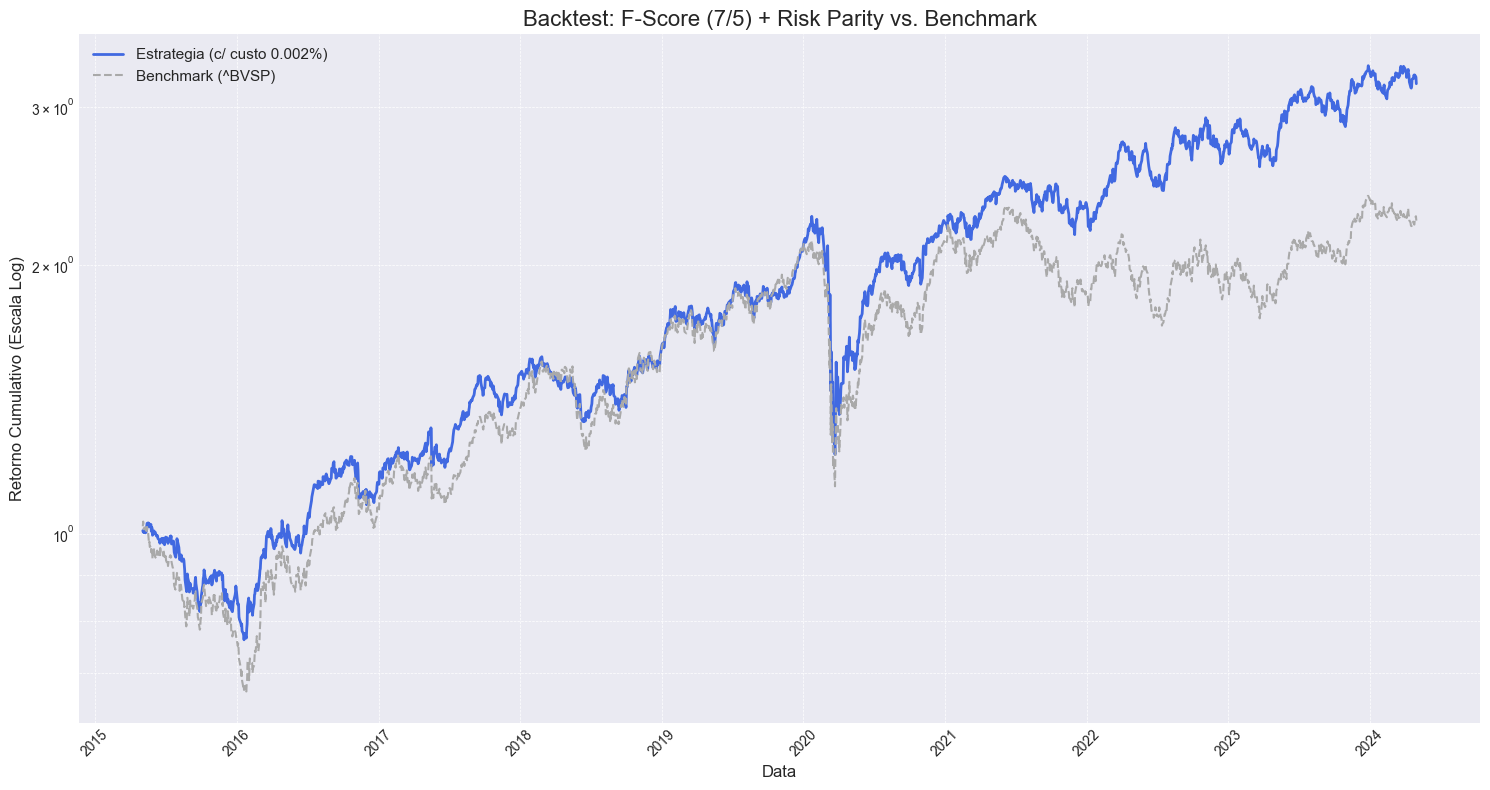

In [20]:
if __name__ == "__main__":
    
    # Parâmetros Dinamicos (Nomes ajustados para bater com a função)
    PARAMETROS = {
        "FScorepath": "fscore.parquet",
        "MapPath": "cnpjs.csv",

        # FILTRO
        "FscoreCompra": 7,
        "FscoreVenda": 5,
        "portfolioAtivosMax": 15,
        "LiquidezMinima": 500_000,

        # BACKTEST
        "RebalanceamentoData": "05-01",
        "AnoInicio": 2015,
        "AnoFim": 2023,
        "Ibov": "^BVSP"
    }

    backtest(**PARAMETROS)